In [1]:
import numpy as np
import matplotlib.pyplot as plt

# RJMCMC
Ref: https://www.colorado.edu/amath/sites/default/files/attached-files/rjmcmc.pdf

Traditionally MCMC has fixed parameters. Fror example If we have choice between two models with model A and Model B with one and two parameters respectively.
In this case there are three mechanisms possible:

Birth: Model A $\rightarrow$ Model B

Death: Model B $\rightarrow$ Model A

Move: Move within the model to change the parameters.

Therefore the acceptance criteria in this case , should consider both the prior and likelihood from both the models.

### The steps for RJMCMC are as follows
1. Start with Model A with $\theta_{A}$ as parameters.
2. Propose a new model, Model B with $\theta_{B}$ as parameters.
3. Calculate the acceptance ratio $\alpha$
4. Accept/reject the new model parameters based on $\alpha$
5. Repeat the steps.




The problem from MCMC and RJMCMC can be obtained by using a generalised approach. That is the reason of having Jacobian and it is not because dimension'Jumping'. The Jacobian accounts for the trnaformation in parameter space of different dimension ensuring probablity density adjustments. In case of no model jumping it means Jacobian is unity.

In [2]:
###Working with two distribution poissons and negative binomial
def poisson_distribution(x,lmbda):
    return lmbda**x*np.exp(-lmbda)/np.math.factorial(x)

def neg_binomial_distribution(x, r, p):
    from scipy.special import gamma
    return (gamma(r + x) / (np.math.factorial(x) * gamma(r))) * (p ** r) * ((1 - p) ** x)
    

For Poisson,s distribution , we have one parameter mean $\lambda$

Whereas in the case of Negative Bionomial Distribution, we have two parameters $r$ and $p$, The mean is given by $\dfrac{r(1-p)}{p}$

If equate these two we get $p=\dfrac{r}{\lambda+r}$


### Jump from Model 1 to Model 2 and vicecersa


Model 1: $x$(1, $\theta$)=(1, $\lambda$)

Model 2: $x'$(1, $\theta$)=(2, $\lambda'$,$r'$)

#### Jump Model 1 to Model 2

Draw $w \sim U(0,1)$

Using inverse CDF generate $r=-ln(w)$
($\lambda'$, $r'$)=($\lambda$, $-ln(w)$)

$J=|\dfrac{\partial(\lambda',r')}{\partial(\lambda,r)}|$
Acceptance probablity to move from the model 1 to 2

$\alpha((1,\lambda),(2,\lambda',r'))=min({1,\dfrac{\pi(2, \lambda',r'|\vec{x})q(k|k')}{\pi(1,\lambda|\vec{x})})g(w)q(k'|k)} \cdot J)$

#### Jump Model 2 to Model 1

We cannot just do $\lambda'$=h(\lambda,r)=\lambda$
The dimensions has to match!

($\lambda'$, $r'$)=($\lambda$, $\exp(r)$)

$J=|\dfrac{\partial(\lambda',r')}{\partial(\lambda,r)}|$
Acceptance probablity to move from the model 1 to 2

$\alpha((1,\lambda),(2,\lambda',r'))=min({1,\dfrac{\pi(1,\lambda|\vec{x})}{\pi(2, \lambda',r'|\vec{x})q(k|k')})g(w)q(k'|k)} \cdot J)$

In [6]:
import numpy as np
from scipy.stats import poisson, nbinom

def RJMCMC(data, n_iter=10000):
    # Initialize parameters
    model = 1
    lam = 1.0
    r = 2.0
    p = 0.5

    samples = []
    
    for i in range(n_iter):
        if model == 1:
            # Propose switch to Model 2
            w = np.random.uniform(0, 1)
            r_new = -np.log(w) if w > 0 else np.inf
            lam_new = lam
            jacobian = 1 / w if w > 0 else np.inf
            
            # Likelihoods
            poisson_likelihood_current = np.prod([poisson.pmf(x, lam) for x in data])
            nb_likelihood_new = np.prod([nbinom.pmf(x, r_new, lam_new/(lam_new + r_new)) for x in data])
            
            acceptance_ratio = (
                (nb_likelihood_new / poisson_likelihood_current) * jacobian
                if poisson_likelihood_current > 0 else np.inf
            )
            
            if np.random.uniform(0, 1) < acceptance_ratio:
                model = 2
                r = r_new
                
        elif model == 2:
            # Propose switch to Model 1
            w = np.random.uniform(0, 1)
            lam_new = lam
            jacobian = np.exp(-r)
            
            # Likelihoods
            nb_likelihood_current = np.prod([nbinom.pmf(x, r, lam/(lam + r)) for x in data])
            poisson_likelihood_new = np.prod([poisson.pmf(x, lam_new) for x in data])
            
            acceptance_ratio = (
                (poisson_likelihood_new / nb_likelihood_current) * jacobian
                if nb_likelihood_current > 0 else np.inf
            )
            
            if np.random.uniform(0, 1) < acceptance_ratio:
                model = 1
                
        # Store the sample
        samples.append((model, lam, r if model == 2 else None))
    
    return samples

# Helper function to create data
def create_mixed_dataset(size=100):
    poisson_data = np.random.poisson(15, size=size)
    n, p = 10, 0.5
    negative_binomial_data = nbinom.rvs(n, p, size=size)
    mixed_data = np.concatenate([poisson_data, negative_binomial_data])
#     np.random.shuffle(mixed_data)
    return mixed_data

# Generate and run RJMCMC
data = create_mixed_dataset()
samples = RJMCMC(data)


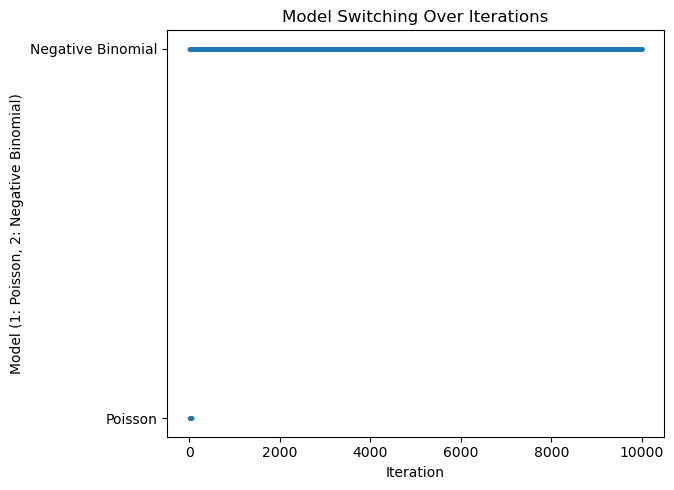

In [12]:

model_counts = [s[0] for s in samples]  # Model (1 for Poisson, 2 for Negative Binomial)
lambda_samples = [s[1] for s in samples if s[0] == 1]  # Lambda samples from Poisson
r_samples = [s[2] for s in samples if s[0] == 2]  # R samples from Negative Binomial

# Plotting the model counts
plt.figure(figsize=(12, 5))

# Model counts
plt.subplot(1, 2, 1)
plt.plot(model_counts, marker='o', linestyle='', markersize=2, alpha=0.5)
plt.title('Model Switching Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Model (1: Poisson, 2: Negative Binomial)')
plt.yticks([1, 2], ['Poisson', 'Negative Binomial'])

# # Lambda and R samples
# plt.subplot(1, 2, 2)
# plt.hist(lambda_samples, bins=30, alpha=0.5, label='Lambda (Poisson)', color='blue', density=True)
# plt.hist(r_samples, bins=30, alpha=0.5, label='R (Negative Binomial)', color='orange', density=True)
# plt.title('Distribution of Parameters')
# plt.xlabel('Parameter Value')
# plt.ylabel('Density')
# plt.legend()

plt.tight_layout()
plt.show()

In [9]:

model_counts

[2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
